In [1]:
# Import all the modules
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model

In [20]:
# Load the dataset
cifar10 = tf.keras.datasets.cifar10

# Create the datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the data ./255
X_train, X_test = X_train/255.0, X_test/255.0

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

X_train.shape:  (50000, 32, 32, 3)
y_train.shape:  (50000, 1)


In [21]:
# number of classes
K = len(np.unique(y_train))
print("number of classes:", K)

number of classes: 10


### Build the model

In [22]:
# Using functional API
i = Input(shape=X_train[0].shape)
x = Conv2D(32, (3,3), strides=2, activation='relu')(i)
x = Conv2D(64, (3,3), strides=2, activation='relu')(x)
x = Conv2D(128, (3,3), strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              118067

In [23]:
# Compile and fit
# Note: make sure you are using the GPU for this!
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
1563/1563 [==============================] - 12s 3ms/step - loss: 1.6990 - accuracy: 0.3757 - val_loss: 1.1979 - val_accuracy: 0.5727
Epoch 2/20
1563/1563 [==============================] - 5s 3ms/step - loss: 1.1871 - accuracy: 0.5721 - val_loss: 1.0530 - val_accuracy: 0.6209
Epoch 3/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9890 - accuracy: 0.6479 - val_loss: 0.9506 - val_accuracy: 0.6625
Epoch 4/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8717 - accuracy: 0.6916 - val_loss: 0.9400 - val_accuracy: 0.6674
Epoch 5/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7592 - accuracy: 0.7294 - val_loss: 0.8629 - val_accuracy: 0.6967
Epoch 6/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6718 - accuracy: 0.7625 - val_loss: 0.8851 - val_accuracy: 0.6946
Epoch 7/20
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5826 - accuracy: 0.7929 - val_loss: 0.8912 - val_accuracy

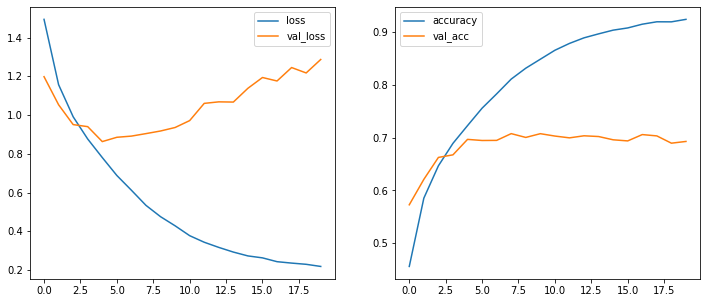

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Plot loss per iteration
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
ax1.legend()

# Plot accuracy per iteration
ax2.plot(r.history['accuracy'], label='accuracy')
ax2.plot(r.history['val_accuracy'], label='val_acc')
ax2.legend()

### Error analysis

In [27]:
# Plot the confusion matrix to see where the model went wrong
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[676  32  49  46  26  13  11  32  73  42]
 [ 10 823   6  19   5  11  22   9  16  79]
 [ 47   6 535 106  93  81  68  42  11  11]
 [ 11   7  44 532  47 201  94  35   7  22]
 [  7   3  57  89 643  48  56  87   7   3]
 [  6   3  27 193  47 616  36  58   6   8]
 [  5   7  25  73  41  32 797  12   5   3]
 [  9   3  20  59  54  66   6 770   0  13]
 [ 52  35  23  34  15  14  12  11 776  28]
 [ 23  85   5  32   6  19  21  25  24 760]]


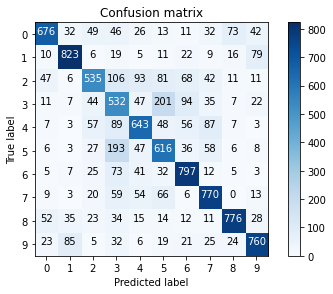

In [28]:
p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))